In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

In [152]:
df = pd.read_csv('../dataset/numerical_data.csv') #only use with full dataset

FEATURE = 'xas'

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 34 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               155361 non-null  float64
 7   formation_energy_per_atom                     155361 non-null  float64
 8   energy_above_hull                             155361 non-null  float64
 9   is_stable                                     15

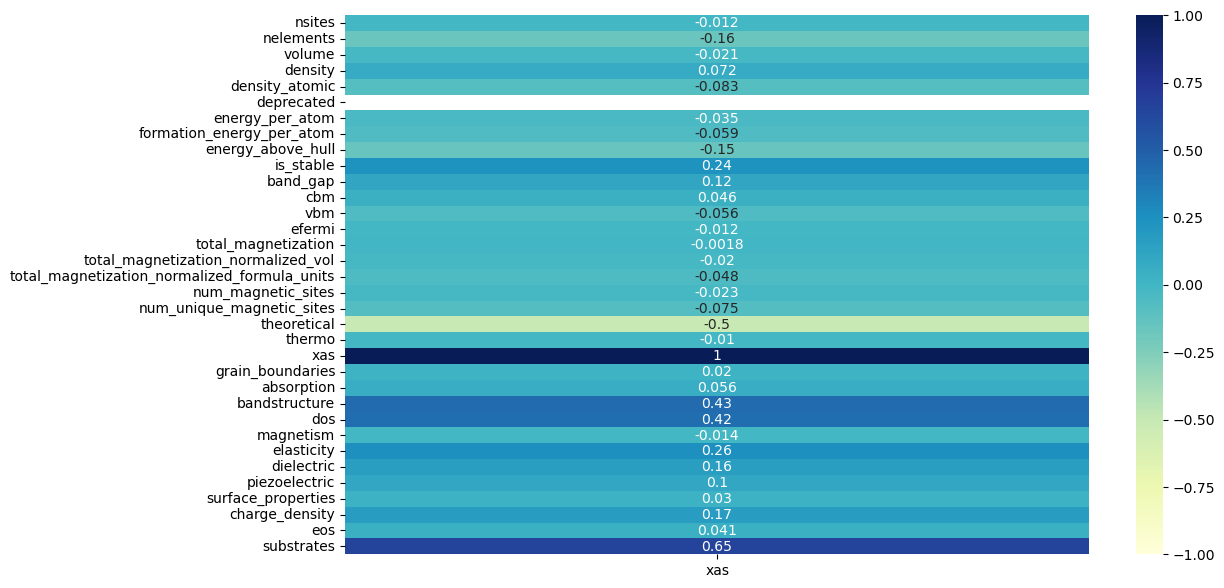

In [154]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 7))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[[FEATURE]]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [155]:
from sklearn.tree import DecisionTreeRegressor

# Split data into real and theoretical subsets and model on real values first
real_df = numerical_df[numerical_df['theoretical'] == 0].copy()
theoretical_df = numerical_df[numerical_df['theoretical'] == 1].copy()

# Drop 'theoretical' column
real_df.drop(['theoretical'], axis=1, inplace=True)
theoretical_df.drop(['theoretical'], axis=1, inplace=True)

# set the feature names
feature_names = numerical_df.drop(['xas', 'theoretical'], axis=1).columns.tolist()


print("Real df shape:", real_df.shape)
print("Theoretical df shape:", theoretical_df.shape)
print("Feature names:", feature_names)


Real df shape: (49772, 33)
Theoretical df shape: (105589, 33)
Feature names: ['nsites', 'nelements', 'volume', 'density', 'density_atomic', 'deprecated', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'band_gap', 'cbm', 'vbm', 'efermi', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'thermo', 'grain_boundaries', 'absorption', 'bandstructure', 'dos', 'magnetism', 'elasticity', 'dielectric', 'piezoelectric', 'surface_properties', 'charge_density', 'eos', 'substrates']


In [156]:
print(real_df[FEATURE].isnull().sum())

0


In [157]:
#Train a model for FEATUER on real molecules

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# Select data corresponding to features in feature_names
X = real_df[feature_names]

y = real_df[FEATURE]

train_X, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.2, random_state=1)

In [158]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(train_X, train_y)

DecisionTreeRegressor()

In [159]:
predictions = dtr_model.predict(test_x)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_y, predictions)

# mean squared error (MSE) and R-squared (R2)
mse = mean_squared_error(test_y, predictions)
r2 = r2_score(test_y, predictions)

print("Mean Squared Error: ", mse)
print("R-squared: ", r2)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  0.22786177105831534
R-squared:  -0.21416577940532
Mean Absolute Error:  0.22786177105831534


In [160]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=250, max_depth=8)
rf_model.fit(train_X, train_y)


RandomForestRegressor(max_depth=8, n_estimators=250)

In [161]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
predictions = rf_model.predict(test_x)

# Evaluate using different metrics
mse = mean_squared_error(test_y, predictions)
rmse = mse ** 0.5
r2 = r2_score(test_y, predictions)

print(f'MSE: {mse}, RMSE: {rmse}, R2: {r2}')

MSE: 0.11684340786517002, RMSE: 0.3418236502425922, R2: 0.3773976796542997


In [162]:
X.drop(columns=["cbm", "vbm"], inplace=True)#drop null values
y.drop(columns=["cbm", "vbm"], inplace=True) 

/var/folders/xk/fhgbj8qj60n54b05mpfnck0w0000gn/T/ipykernel_10427/893966464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=["cbm", "vbm"], inplace=True)#drop null values


In [163]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [164]:
train_X, test_x, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=1)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(train_X)
scaled_X_test = scaler.transform(test_x)

In [165]:
dnn_model = Sequential()
dnn_model.add(Dense(64, activation="relu", input_dim=scaled_X_train.shape[1]))  # Input layer
dnn_model.add(Dense(32, activation="relu"))  # Hidden layer 1
dnn_model.add(Dense(1))  # Output layer (no activation for regression)

dnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss="mean_squared_error")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [166]:
dnn_model.fit(scaled_X_train, train_y, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - loss: 0.2941 - val_loss: 0.1511
Epoch 2/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - loss: 0.1461 - val_loss: 0.1368
Epoch 3/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - loss: 0.1358 - val_loss: 0.1316
Epoch 4/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - loss: 0.1326 - val_loss: 0.1285
Epoch 5/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - loss: 0.1289 - val_loss: 0.1271
Epoch 6/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - loss: 0.1268 - val_loss: 0.1254
Epoch 7/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - loss: 0.1227 - val_loss: 0.1246
Epoch 8/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 0.1234 - val_loss: 0.1239
Epoch 9/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - loss: 0.1234 - val_loss: 0.1230
Epoch 10/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - loss: 0.1200 - val_loss: 0.1226
Epoch 11/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - loss: 0.1190 - val_loss: 0.1231
Epoch 12/100
996/99

In [167]:
mse = dnn_model.evaluate(scaled_X_test, test_y)
print("Mean Squared Error:", mse)

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.1217
Mean Squared Error: 0.11998707056045532


In [168]:
dnn_predictions = dnn_model.predict(scaled_X_test)

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


In [169]:
r2 = r2_score(test_y, dnn_predictions)
print(r2)

0.3533039093017578
